In [1]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import cv2
import tensorflow as tf

Text(0.5, 1.0, 'data/test_dirty_mnist_2nd')

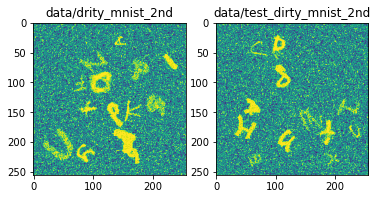

In [2]:
# 이미지 미리보기
import glob

fig, axes = plt.subplots(nrows=1, ncols=2)

# 훈련 데이터
wfiles = glob.glob("data/dirty_mnist_2nd/*") # 리스트로 불러오기 위함
wfiles = sorted(wfiles)
img = plt.imread(wfiles[0])
axes[0].imshow(img)
axes[0].set_title("data/drity_mnist_2nd")

# 예측 데이터
wfiles = glob.glob("data/test_dirty_mnist_2nd/*") # 리스트로 불러오기 위함
wfiles = sorted(wfiles)
img = plt.imread(wfiles[0])
axes[1].imshow(img)
axes[1].set_title("data/test_dirty_mnist_2nd")

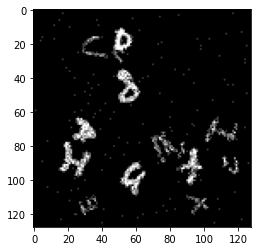

In [3]:
# cv로 이미지 불러오기
img = cv2.imread(wfiles[0])
img = cv2.threshold(img, 254, 255, 0)[1]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
plt.imshow(img)

In [4]:
# 훈련 데이터셋의 정답값
train_label = pd.read_csv("data/dirty_mnist_2nd_answer.csv", nrows=10000, index_col=0)
print(train_label.shape)
train_label.head()

(10000, 26)


,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1
1,1,0,0,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,1,0,1,1,1,0
3,0,0,1,0,0,0,1,1,0,0,...,1,0,1,1,0,1,1,0,1,0
4,0,1,0,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [5]:
# 이미지 리스트로 불러오는 함수
import glob

def img_folder_read(folder_name):

    img_files = []

    wfiles = glob.glob(f"./data/{folder_name}/*")
    wfiles = sorted(wfiles)
    
    if folder_name == "dirty_mnist_2nd":
        wfiles = wfiles[:10000]
    
    
    for i in tqdm.tqdm(wfiles):
        img = cv2.imread(i)
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.threshold(img, 254, 255, 0)[1]
        img_files.append(img)
   

    return img_files

In [6]:
# 훈련용, 예측용 이미지 데이터셋 만들기
train_input = img_folder_read("dirty_mnist_2nd")
test_input = img_folder_read("test_dirty_mnist_2nd")

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1110.18it/s]


In [7]:
# 불러온 데이터셋 확인
len(train_input), train_input[0].shape, len(test_input), test_input[0].shape

(10000, (128, 128, 3), 5000, (128, 128, 3))

In [8]:
# numpy array형태로 변환
train_arr = np.array(train_input)
test_arr = np.array(test_input)

train_arr.shape, test_arr.shape

((10000, 128, 128, 3), (5000, 128, 128, 3))

In [9]:
# train_test 데이터셋 분리
from sklearn.model_selection import train_test_split

x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(
                                                        train_arr, train_label,
                                                        test_size=0.15, random_state=42)

x_train_raw.shape, x_valid_raw.shape, y_train_raw.shape, y_valid_raw.shape

((8500, 128, 128, 3), (1500, 128, 128, 3), (8500, 26), (1500, 26))

In [10]:
# # 이미지 데이터 정규화
# x_train = x_train_raw / 255
# x_valid = x_valid_raw / 255
# x_test = test_arr / 255

# x_train[0].max(), x_valid[0].max(), x_test[0].max()

(1.0, 1.0, 1.0)

In [10]:
#augmentation이 적용된 image들을 시각화 해주는 함수
def show_aug_image(img, generator, n_images=4):

    # ImageDataGenerator는 여러개의 image를 입력으로 받기 때문에 4차원으로 입력 해야함.
    image_batch = np.expand_dims(img, axis=0)

    # featurewise_center or featurewise_std_normalization or zca_whitening 가 True일때만 fit 해주어야함
    generator.fit(image_batch) 
    # flow로 image batch를 generator에 넣어주어야함.
    data_gen_iter = generator.flow(image_batch)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_images, figsize=(24, 8))

    for i in range(n_images):
        #generator에 batch size 만큼 augmentation 적용(매번 적용이 다름)
        aug_image_batch = next(data_gen_iter)
        aug_image = np.squeeze(aug_image_batch)
        aug_image = aug_image.astype('int')
        axs[i].imshow(aug_image)

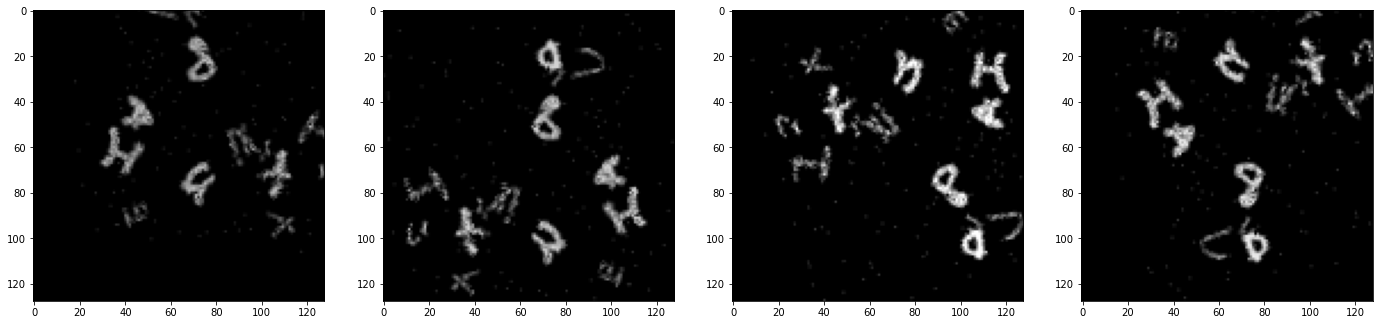

In [14]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True,
    #rescale=1/255.0 # 학습시 적용, 시각화를 위해 임시로 주석처리
)

show_aug_image(img, data_generator, n_images=4)

In [15]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.0
)

In [17]:
train_generator = data_generator.flow(
        x=x_train_raw,
        y=np.array(y_train_raw), 
        batch_size=32)

In [18]:
valid_generator = data_generator.flow(
        x=x_valid_raw,
        y=np.array(y_valid_raw), 
        batch_size=32)

In [24]:
# 모델 생성
model = tf.keras.Sequential([
    
    tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(128, 128, 3)),
    
    tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu",
                           padding="same"),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu",
                           padding="same"),
    tf.keras.layers.MaxPooling2D(2),

    # FC
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),

    # 출력층
    tf.keras.layers.Dense(26, activation="sigmoid")
])

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          147488    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)               

In [26]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
# checkpoint : 훈련 후 가장 성능이 좋았던 모델이 저장됨
# restore_best_weights=True : loss 값이 가장 낮은 파라미터로 모델을 되돌림
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy", restore_best_weights=True)

history = model.fit_generator(train_generator, epochs=5, verbose=1,
                   validation_data=valid_generator,
                   callbacks=[checkpoint, early_stopping])

Epoch 1/5


C:\Users\Jinseon\AppData\Local\Temp\ipykernel_10948\1259205882.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, verbose=1,


266/266 [==============================] - 4032s 15s/step - loss: 0.6908 - accuracy: 0.0368 - val_loss: 0.6906 - val_accuracy: 6.6667e-04
Epoch 2/5
253/266 [===========================>..] - ETA: 29:17 - loss: 0.6905 - accuracy: 0.0143

In [22]:
history = pd.DataFrame(history.history)
history[:5]

,loss,accuracy,val_loss,val_accuracy
0,1.030950e+08,0.002000,2.387708e+08,0.007333
1,1.918676e+09,0.009294,1.730508e+09,0.000667
2,8.246496e+09,0.012706,4.677696e+09,0.000000


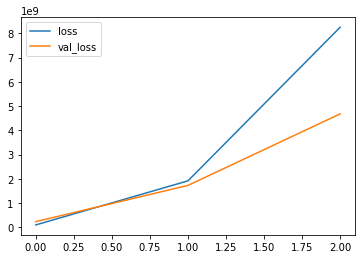

In [23]:
history[["loss", "val_loss"]].plot();

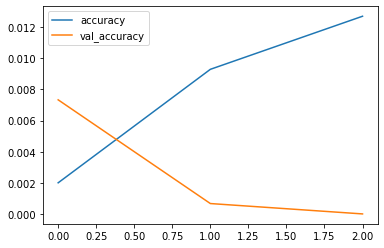

In [24]:
history[["accuracy", "val_accuracy"]].plot();

In [25]:
model.evaluate(x_valid, y_valid_raw)

47/47 [==============================] - 2s 50ms/step - loss: 238770832.0000 - accuracy: 0.0073


[238770832.0, 0.007333333138376474]

In [ ]:
pred = model.predict(x_test)
print(pred)
pred